# Steps performed to execute this project

# Steps Executed in the Project

## 1. Library Installation and Import
- **Libraries**: Essential libraries such as `datasets`, `torch`, `sentence-transformers`, `sklearn`, and `nltk` were installed to support data processing, modeling, and text analysis.
- **Importing Libraries**: Various libraries were imported, including those for text preprocessing (`nltk`, `textblob`), feature extraction (`sklearn`), and machine learning (`svm`, `xgb`, etc.).

## 2. Data Preprocessing
- **Handling Missing Data**: Rows with missing responses were dropped using `dropna()`, ensuring that only complete rows were processed.
- **Text Cleaning**: A custom text-cleaning function was created to preprocess text data. It includes:
  - Removing punctuation
  - Converting text to lowercase
  - Tokenizing and removing stopwords
  - Lemmatizing words to reduce them to their base forms
- **Adding Length Features**: Conversation length features were added to both the 'Context' and 'Response' columns to track the number of words in each entry.

## 3. Exploratory Data Analysis (EDA)
- **Word Clouds**: Word clouds were generated for the 'Context' and 'Response' columns to visualize the most frequent terms in both types of text.
- **Sentiment Analysis**: Sentiment scores for the conversations and responses were calculated using the `TextBlob` library, helping to understand the polarity of the text.
- **Distribution Plots**: Histograms were created to visualize sentiment distributions and conversation lengths.

## 4. Topic Modeling
- **Latent Dirichlet Allocation (LDA)**: LDA was used to identify hidden topics within the 'Context' and 'Response' texts. This helped uncover underlying themes and improve text analysis.
- **Topic Visualization**: Topics discovered by LDA were displayed with the most common terms for better interpretability.

## 5. Text Vectorization and Embedding
- **Document-Term Matrix (DTM)**: A `CountVectorizer` was used to convert the text data into a matrix of token counts for further analysis.
- **Embeddings Generation**: A `SentenceTransformer` model (`all-MiniLM-L12-v2`) was used to generate dense vector embeddings for the responses. These embeddings represent the semantic content of each response in a lower-dimensional space.

## 6. Clustering
- **KMeans Clustering**: The embeddings were clustered using the KMeans algorithm, with an "elbow method" plot to determine the optimal number of clusters. This helped categorize the responses into meaningful clusters (e.g., 'Direct Advice', 'Empathy', 'Reflection').
- **Cluster Labeling**: Manually labeled the clusters to interpret them, which were then added as a new column in the DataFrame.

## 7. Dimensionality Reduction and Visualization
- **t-SNE**: To visualize the clusters in a 2D space, t-SNE was applied to the embeddings, helping to understand how the responses are grouped in a reduced feature space.

## 8. Model Training and Evaluation
- **Train-Test Split**: The data was split into training and test sets (80% training, 20% testing) to evaluate model performance.
- **Multiple Models**: Several classifiers were trained and evaluated:
  - Logistic Regression
  - Random Forest Classifier
  - Support Vector Machine (SVM)
  - K-Nearest Neighbors (KNN)
  - XGBoost
- **Evaluation**: Accuracy scores and other metrics were computed for each model to identify the best performing model.

## 9. Deployment (Model Serving with Gradio)
- **Support Vector Machine (SVM)**: The best model, SVM, was selected for production use.
- **Hugging Face Model (T5)**: The T5 model from Hugging Face was integrated for generating advice from text input, where the SVM model classifies the type of response and the T5 model generates suitable advice.
- **Gradio Interface**: A user-friendly interface was created with Gradio to allow interaction with the models. It accepts free-text input and displays both the predicted response type and the generated advice in real-time.

---

## Why These Steps Were Chosen:

1. **Data Preprocessing**: Necessary to clean and prepare the text data for accurate analysis and modeling. Text preprocessing helps improve the quality of input to models.
2. **EDA and Visualization**: Essential to understand the data better and gain insights into the text features, sentiment distribution, and conversation structure.
3. **Topic Modeling (LDA)**: Helps uncover underlying themes within the data, offering better insights into how the conversations and responses are structured.
4. **Clustering**: Important for grouping similar responses together, which aids in identifying response types and improving classification accuracy.
5. **Model Evaluation**: Multiple models were tested to determine the best one for classifying response types based on the features extracted from text.
6. **Deployment**: Gradio was chosen for quick deployment because it provides a simple interface for showcasing the models and allows for interaction with real-world text inputs.

This structured process enables the development of a mental health counseling assistant that not only classifies response types but also generates meaningful advice for counselors based on patient input.

# Download and import all the necessary libraries

In [56]:
# Download necessary libraries
!pip install datasets torch contractions textblob kaleido sentence-transformers gradio

# Import libraries
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sentence_transformers import SentenceTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation

from textblob import TextBlob
from wordcloud import WordCloud

from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer

import gradio as gr
import joblib

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import xgboost as xgb

# Download required NLTK related items
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load and Explore the Dataset

# Explore and understand the data

In [2]:
# Load the dataset into a dataframe
df = pd.read_csv("train.csv")

In [3]:
# First 5 rows of the dataframe
df.head()

,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [4]:
# Last 5 rows of the dataframe
df.tail()

,Context,Response
3507,My grandson's step-mother sends him to school ...,Absolutely not! It is never in a child's best ...
3508,My boyfriend is in recovery from drug addictio...,I'm sorry you have tension between you and you...
3509,The birth mother attempted suicide several tim...,"The true answer is, ""no one can really say wit..."
3510,I think adult life is making him depressed and...,How do you help yourself to believe you requir...
3511,I just took a job that requires me to travel f...,hmm this is a tough one!


In [5]:
# Shape of the dataframe
df.shape

(3512, 2)

In [6]:
# Columns of the dataframe
df.columns

Index(['Context', 'Response'], dtype='object')

In [7]:
# Access the first row for sample view of the data
first_row = df.iloc[20]

# Print each value separately
print(f"Context: {first_row['Context']}\n")
print(f"Response: {first_row['Response']}")

Context: I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

Response: The feeling of being worthless is caused by your inside being not matching your outside result. Your comparison to others and you thinking you need to be someone other than who you are. You are not worthless. No one is worthless. You need to find your worth and not let yourself talk yourself out of the good you find in yourself. I hope these words resonate with you and that you start looking for your worth even if it’s as simple as I am able to get out of bed and call someone and make a joke.


In [8]:
# Fetch information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB


In [9]:
# Examine the datatypes of each column
df.dtypes

,0
Context,object
Response,object


In [10]:
# Check for missing values
df.isnull().sum()

,0
Context,0
Response,4


## How to Handle Missing Values?

**When to Drop Missing Rows:**
- If the number of missing rows is small (like here, 4 out of 3512 entries is ~0.1%), dropping them won't significantly impact your dataset.
- This is the simplest and safest option when the missing data isn't recoverable or meaningful.
***Recommended if:*** The missing responses are completely blank or not meaningful for analysis or modeling.

**When to Impute Missing Values:**
- If the missing responses are important for maintaining the context of conversations, you might want to impute them with placeholders (e.g., "No Response" or "Unavailable").
- This ensures no context is entirely discarded but might dilute the quality slightly if too many placeholders exist.
- ***Recommended if:*** The missing responses are in contexts that might still be useful for other analyses (e.g., analyzing patient questions or topics).

## Final Decision on Missing Values?

- As there are 3512 entries in the dataset and for this usecase, we need both Context and Response.
- If we impute missing values of Response column with **Unavailable** values, it will affect the goal of this task.
- Hence, I am removing those 4 missing values related rows.

In [11]:
# Drop rows with missing Response
df = df.dropna(subset=['Response'])

# Verify the result
print("\nAfter removing missing Response rows:")
df.info()


After removing missing Response rows:
<class 'pandas.core.frame.DataFrame'>
Index: 3508 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3508 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 82.2+ KB


# Exploratory Data Analysis

## Text Analysis for 'Context' Column

In [12]:
# Generate word cloud for conversations
text = " ".join(df['Context'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

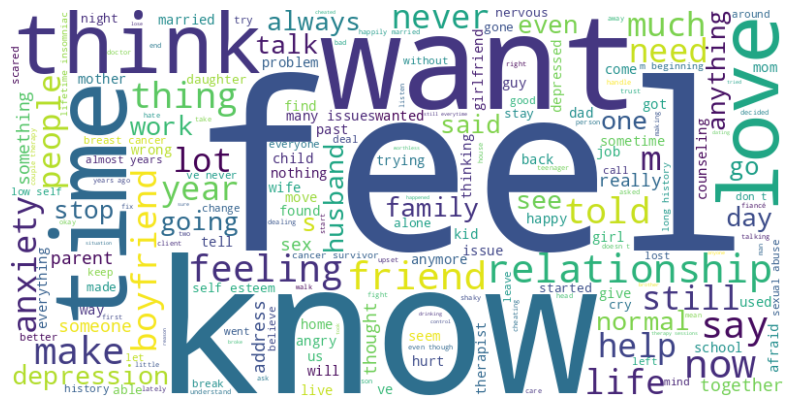

In [13]:
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Text Analysis for 'Response' Column

In [14]:
# Generate word cloud for conversations
text = " ".join(df['Response'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

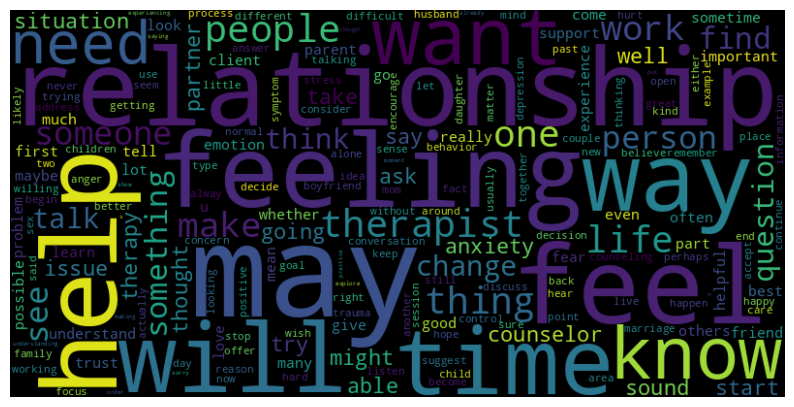

In [15]:
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis for 'Context' Column

In [16]:
# Add a sentiment score for each conversation
df['sentiment'] = df['Context'].apply(lambda x: TextBlob(x).sentiment.polarity)
df[['Context', 'sentiment']].head()

,Context,sentiment
0,I'm going through some things with my feelings...,-0.516667
1,I'm going through some things with my feelings...,-0.516667
2,I'm going through some things with my feelings...,-0.516667
3,I'm going through some things with my feelings...,-0.516667
4,I'm going through some things with my feelings...,-0.516667


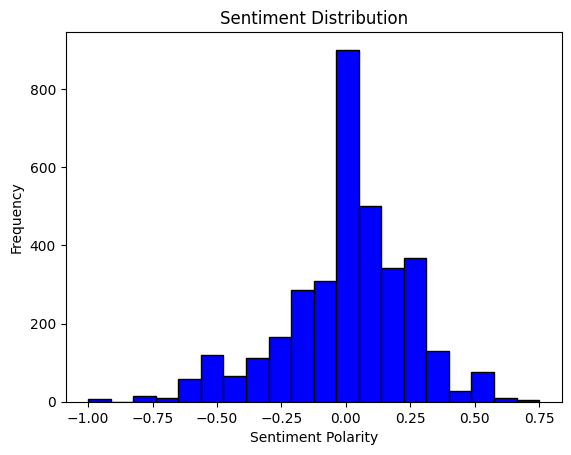

In [17]:
# Plot sentiment distribution
plt.hist(df['sentiment'], bins=20, color='blue', edgecolor='black')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

## Sentiment Analysis for 'Response' Column

In [18]:
# Add a sentiment score for each conversation
df['sentiment_response'] = df['Response'].apply(lambda x: TextBlob(x).sentiment.polarity)
df[['Response', 'sentiment_response']].head()

,Response,sentiment_response
0,"If everyone thinks you're worthless, then mayb...",0.077374
1,"Hello, and thank you for your question and see...",0.167409
2,First thing I'd suggest is getting the sleep y...,0.225000
3,Therapy is essential for those that are feelin...,0.110417
4,I first want to let you know that you are not ...,0.196591


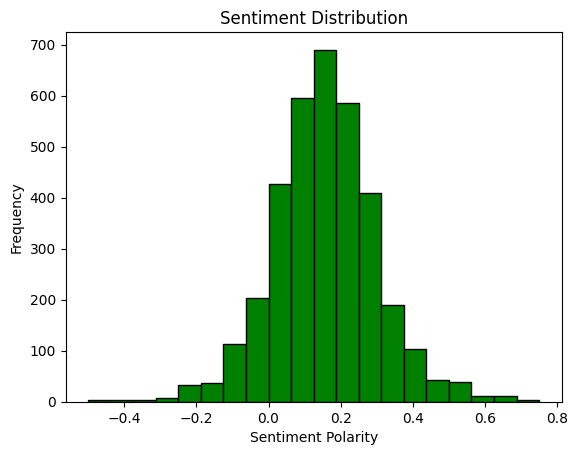

In [19]:
# Plot sentiment distribution
plt.hist(df['sentiment_response'], bins=20, color='green', edgecolor='black')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

## Topic Modeling for 'Context' Column

In [20]:
# Convert text to a document-term matrix
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
dtm = vectorizer.fit_transform(df['Context'])

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}:")
    print([vectorizer.get_feature_names_out()[j] for j in topic.argsort()[-10:]])

Topic 0:
['years', 've', 'talk', 'help', 'want', 'don', 'like', 'depression', 'anxiety', 'feel']
Topic 1:
['day', 'child', 'like', 'relationship', 'normal', 'know', 'years', 'don', 'just', 've']
Topic 2:
['depression', 'anxiety', 'self', 'abuse', 'sexual', 'address', 'history', 've', 'issues', 'counseling']
Topic 3:
['just', 'times', 'love', 'boyfriend', 'got', 'told', 'sex', 'don', 'does', 'time']
Topic 4:
['make', 'things', 'people', 'really', 'want', 'just', 'don', 'know', 'like', 'feel']


## Topic Modeling for 'Response' column

In [21]:
# Convert text to a document-term matrix
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
dtm = vectorizer.fit_transform(df['Response'])

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}:")
    print([vectorizer.get_feature_names_out()[j] for j in topic.argsort()[-10:]])

Topic 0:
['need', 'things', 'good', 'don', 'want', 'relationship', 'like', 'know', 'time', 'feel']
Topic 1:
['work', 'like', 'support', 'feel', 'anxiety', 'therapy', 'counseling', 'counselor', 'help', 'therapist']
Topic 2:
['time', 'love', 'partner', 'way', 'like', 'life', 'feel', 'person', 'people', 'relationship']
Topic 3:
['si', 'te', 'para', 'es', 'el', 'tu', 'en', 'la', 'client', 'que']
Topic 4:
['things', 'people', 'way', 'like', 'self', 'time', 'life', 'anxiety', 'thoughts', 'help']


# Clean and Preprocess the Data

In [22]:
# Define text cleaning function
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

In [23]:
# Apply text cleaning
df['cleaned_context'] = df['Context'].apply(clean_text)
df[['Context', 'cleaned_context']].head(20)

,Context,cleaned_context
0,I'm going through some things with my feelings...,im going thing feeling barely sleep nothing th...
1,I'm going through some things with my feelings...,im going thing feeling barely sleep nothing th...
2,I'm going through some things with my feelings...,im going thing feeling barely sleep nothing th...
3,I'm going through some things with my feelings...,im going thing feeling barely sleep nothing th...
4,I'm going through some things with my feelings...,im going thing feeling barely sleep nothing th...
5,I'm going through some things with my feelings...,im going thing feeling barely sleep nothing th...
6,I'm going through some things with my feelings...,im going thing feeling barely sleep nothing th...
7,I'm going through some things with my feelings...,im going thing feeling barely sleep nothing th...
8,I'm going through some things with my feelings...,im going thing feeling barely sleep nothing th...
9,I'm going through some things with my feelings...,im going thing feeling barely sleep nothing th...


In [24]:
# Apply text cleaning for 'Response' column
df['cleaned_response'] = df['Response'].apply(clean_text)
df[['Response', 'cleaned_response']].head(20)

,Response,cleaned_response
0,"If everyone thinks you're worthless, then mayb...",everyone think youre worthless maybe need find...
1,"Hello, and thank you for your question and see...",hello thank question seeking advice feeling wo...
2,First thing I'd suggest is getting the sleep y...,first thing id suggest getting sleep need impa...
3,Therapy is essential for those that are feelin...,therapy essential feeling depressed worthless ...
4,I first want to let you know that you are not ...,first want let know alone feeling always someo...
5,"Heck, sure thing, hun!Feelings of 'depression'...",heck sure thing hunfeelings depression deeplyr...
6,You are exhibiting some specific traits of a p...,exhibiting specific trait particular temperame...
7,That is intense. Depression is a liar. Sometim...,intense depression liar sometimes depression p...
8,It sounds like you may be putting yourself las...,sound like may putting last wrote want fix iss...
9,It must be really difficult to experience what...,must really difficult experience going right t...


# Visualize Insights

## Conversation Length Distribution for 'Context' column

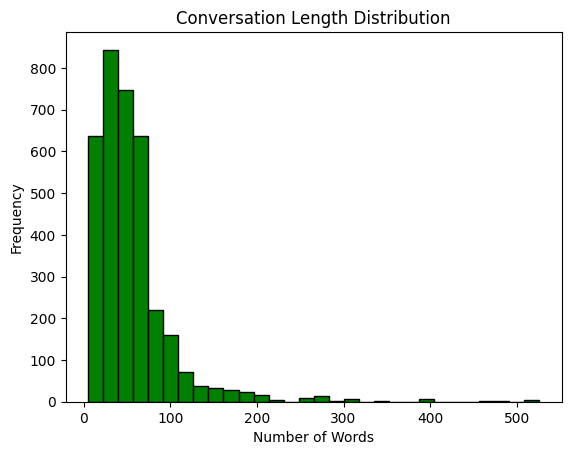

In [25]:
# Add conversation length
df['conversation_length_context'] = df['Context'].apply(lambda x: len(x.split()))

# Plot distribution
plt.hist(df['conversation_length_context'], bins=30, color='green', edgecolor='black')
plt.title('Conversation Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Conversation Length Distribution for 'Response' column

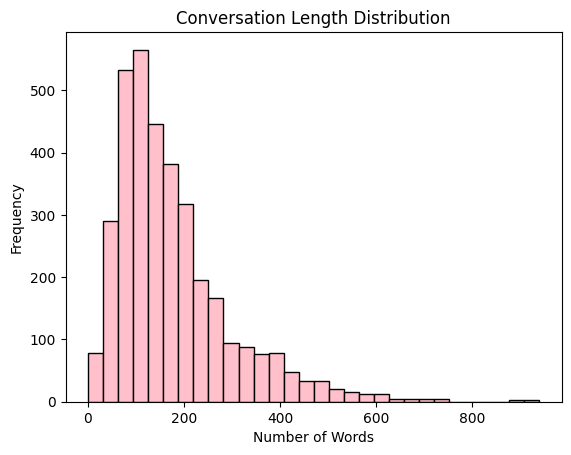

In [26]:
# Add conversation length
df['conversation_length_response'] = df['Response'].apply(lambda x: len(x.split()))

# Plot distribution
plt.hist(df['conversation_length_response'], bins=30, color='pink', edgecolor='black')
plt.title('Conversation Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Common Words in 'Context' column

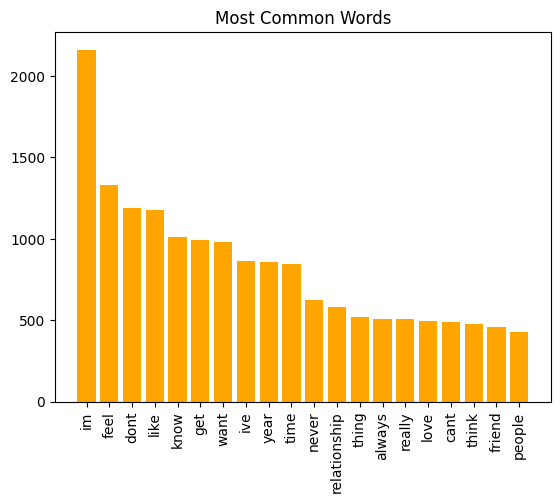

In [27]:
# Get most common words
all_words = " ".join(df['cleaned_context']).split()
word_counts = Counter(all_words).most_common(20)

# Plot common words
words, counts = zip(*word_counts)
plt.bar(words, counts, color='orange')
plt.xticks(rotation=90)
plt.title('Most Common Words')
plt.show()

## Common Words in 'Response' column

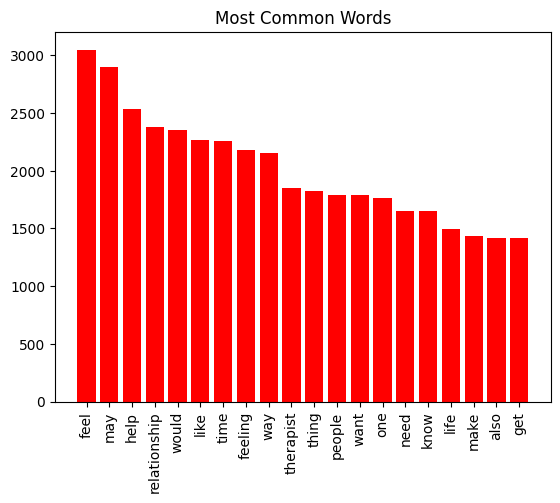

In [28]:
# Get most common words
all_words = " ".join(df['cleaned_response']).split()
word_counts = Counter(all_words).most_common(20)

# Plot common words
words, counts = zip(*word_counts)
plt.bar(words, counts, color='red')
plt.xticks(rotation=90)
plt.title('Most Common Words')
plt.show()

# Create BERT Embeddings for Responses

## We’ll use SBERT (Sentence-BERT) to generate embeddings for the responses. SBERT is a pre-trained model based on BERT, which is optimized for sentence-level embeddings.

In [29]:
# Use all-mpnet-base-v2 for better embeddings
model = SentenceTransformer('all-MiniLM-L12-v2')

# Generate embeddings for each response
embeddings = model.encode(df['cleaned_response'].tolist(), convert_to_tensor=False)

# Add the embeddings to the DataFrame as a list of lists
df['embeddings'] = embeddings.tolist()

# Check the first few rows to verify
df[['cleaned_response', 'embeddings']].head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,cleaned_response,embeddings
0,everyone think youre worthless maybe need find...,"[-0.04851763695478439, 0.009545514360070229, -..."
1,hello thank question seeking advice feeling wo...,"[0.057775139808654785, -0.016426555812358856, ..."
2,first thing id suggest getting sleep need impa...,"[0.02544749528169632, -0.033759187906980515, 0..."
3,therapy essential feeling depressed worthless ...,"[-0.018198197707533836, 0.0303801316767931, 0...."
4,first want let know alone feeling always someo...,"[0.02688952535390854, -0.021212181076407433, 0..."


In [30]:
df.columns

Index(['Context', 'Response', 'sentiment', 'sentiment_response',
       'cleaned_context', 'cleaned_response', 'conversation_length_context',
       'conversation_length_response', 'embeddings'],
      dtype='object')

## Perform K-Means Clustering

Now, we’ll apply K-Means clustering on the embeddings. The idea is that similar responses will be grouped into clusters. You can then manually assign labels to these clusters based on the response styles.

From the Elbow Method curve below, it seems like the optimal number of clusters might be around 3 based on the sharp drop in WCSS (Within-Cluster Sum of Squares) and the point where the decrease in WCSS becomes more gradual. This suggests that 3 clusters could be a good choice, as adding more clusters doesn't yield much improvement.

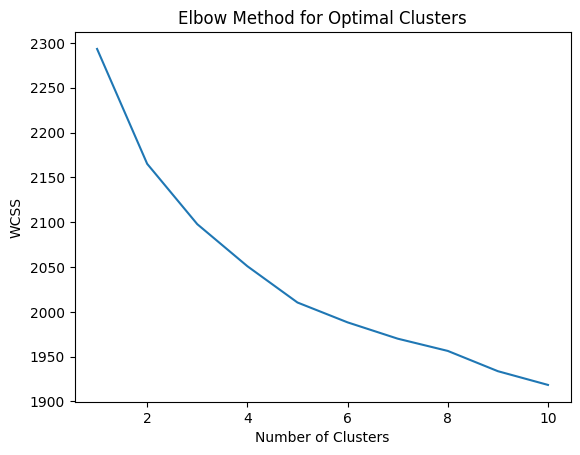

In [31]:
wcss = []
for n_clusters in range(1, 11):  # 1 to 10 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(np.array(embeddings))  # Use the embeddings
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [32]:
# Set number of clusters
n_clusters = 3

# Fit KMeans to the embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Convert the list of embeddings into a NumPy array for KMeans
embeddings_array = np.array(df['embeddings'].tolist())

# Fit the model and predict clusters
df['cluster'] = kmeans.fit_predict(embeddings_array)

# Display the first few rows with cluster labels
df[['Response', 'cluster']].head(20)

,Response,cluster
0,"If everyone thinks you're worthless, then mayb...",2
1,"Hello, and thank you for your question and see...",2
2,First thing I'd suggest is getting the sleep y...,2
3,Therapy is essential for those that are feelin...,1
4,I first want to let you know that you are not ...,2
5,"Heck, sure thing, hun!Feelings of 'depression'...",1
6,You are exhibiting some specific traits of a p...,1
7,That is intense. Depression is a liar. Sometim...,2
8,It sounds like you may be putting yourself las...,2
9,It must be really difficult to experience what...,1


## Analyze and Assign Labels to Clusters

We can now review the responses in each cluster to understand the groupings and assign labels to the clusters (e.g., Direct Advice, Empathy, etc.).

In [33]:
# Inspect the responses in each cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster} Responses:")
    print(df[df['cluster'] == cluster]['cleaned_response'].head(5))  # Show 5 responses from each cluster


Cluster 0 Responses:
83    important take look inside see whats going cau...
89    first step always medical rule youre sure prob...
90    im working men type situation always suggest m...
91    starter know normal experience many men point ...
93    havent already please see doctor ed caused num...
Name: cleaned_response, dtype: object

Cluster 1 Responses:
3     therapy essential feeling depressed worthless ...
5     heck sure thing hunfeelings depression deeplyr...
6     exhibiting specific trait particular temperame...
9     must really difficult experience going right t...
11    im sorry hear youre feeling intense emotion wo...
Name: cleaned_response, dtype: object

Cluster 2 Responses:
0    everyone think youre worthless maybe need find...
1    hello thank question seeking advice feeling wo...
2    first thing id suggest getting sleep need impa...
4    first want let know alone feeling always someo...
7    intense depression liar sometimes depression p...
Name: cleaned_response,

## Add Labels to DataFrame

In [34]:
# Manually label the clusters
cluster_labels = {
    0: 'Direct Advice',    # Example: Cluster 0 could be 'Direct Advice'
    1: 'Empathy',          # Example: Cluster 1 could be 'Empathy'
    2: 'Reflection'        # Example: Cluster 2 could be 'Reflection'
}

# Add the labels to the DataFrame
df['response_type'] = df['cluster'].map(cluster_labels)

# View the final DataFrame with labels
df[['cleaned_response', 'response_type']].tail(10)

,cleaned_response,response_type
3502,hi im sorry tough time situation worked number...,Reflection
3503,helloit sound like really concerned daughter n...,Reflection
3504,hi excellent question think answer probably va...,Empathy
3505,hi someone practiced clinical psychologist 25 ...,Empathy
3506,thing confuses child parent come go life child...,Reflection
3507,absolutely never child best interest use humil...,Reflection
3508,im sorry tension bfa relationship mean two peo...,Direct Advice
3509,true answer one really say certaintythe variab...,Reflection
3510,help believe require offer youwhat get relatio...,Direct Advice
3511,hmm tough one,Reflection


## Visualize the Clusters

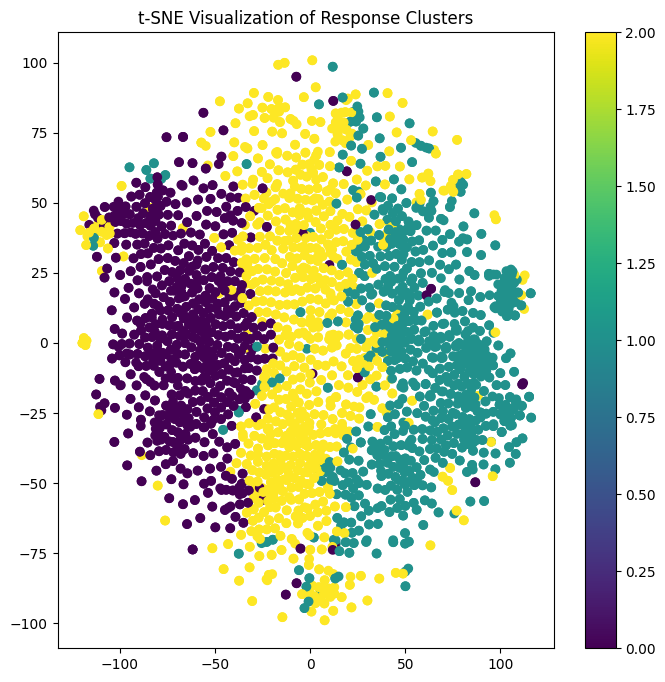

In [35]:
# Reduce the dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(np.array(embeddings))

# Plot the clusters
plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df['cluster'], cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Response Clusters')
plt.show()

In [36]:
df[['cleaned_response', 'response_type']].head(25)

,cleaned_response,response_type
0,everyone think youre worthless maybe need find...,Reflection
1,hello thank question seeking advice feeling wo...,Reflection
2,first thing id suggest getting sleep need impa...,Reflection
3,therapy essential feeling depressed worthless ...,Empathy
4,first want let know alone feeling always someo...,Reflection
5,heck sure thing hunfeelings depression deeplyr...,Empathy
6,exhibiting specific trait particular temperame...,Empathy
7,intense depression liar sometimes depression p...,Reflection
8,sound like may putting last wrote want fix iss...,Reflection
9,must really difficult experience going right t...,Empathy


# Model for Response Classification (BERT/SBERT)

Since we've classified the responses into different categories (e.g., Direct Advice, Empathy, Reflection), the next step is to train a classification model using this labeled data.

## Preprocessing and Preparing Data

Now that we have our `response_type` labels, you can use these to create the training data for a classifier. Here's what you need to do:

- ***Prepare our features:*** Use the embeddings for each `cleaned_response` as features for classification.

- ***Prepare our labels:*** The `response_type` column contains your target labels (Direct Advice, Empathy, or Reflection).

## Split the data into training and test sets

We'll split the data so we can train and evaluate the model.

In [37]:
# Split the data into training and test sets
X = np.array(df['embeddings'].tolist())  # Embeddings
y = df['response_type']  # Labels (response type)

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Let us move on to trying multiple classifiers and evaluating their performance. Here’s a list of classification algorithms you can try, all of which should work well in a Google Colab environment (with or without GPU)

### Logistic Regression

In [38]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.4f}")

Logistic Regression Accuracy: 0.9843


### Random Forest Classifier

In [39]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.9687


### Support Vector Machine (SVM)

In [40]:
# Initialize the Support Vector Classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the model
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

SVM Accuracy: 0.9915


### K-Nearest Neighbors (KNN)

In [41]:
# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn_classifier.predict(X_test)

# Evaluate the model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {knn_accuracy:.4f}")

KNN Accuracy: 0.8818


### XGBoost

In [42]:
from sklearn.preprocessing import LabelEncoder

# Encode labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize the XGBoost model
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Train the model
xgb_classifier.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_xgb = xgb_classifier.predict(X_test)

# Convert predictions back to original labels
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb_labels)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.9644


## Overall comparison of all the models

- **Logistic Regression:** Excellent performance across all categories with accuracy of 98%. This is a strong baseline model.

- **Random Forest:** Slightly lower accuracy than Logistic Regression (97%) but still strong performance, particularly with good recall values.

- **SVM:** Outstanding performance with 99% accuracy. SVM is excelling, particularly in precision and recall, making it a reliable model.

- **KNN:** The accuracy dropped to 88%, which is still good but lower than the other models. It has lower performance for the "Reflection" category.

- **XGBoost:** Achieved 96% accuracy with good precision and recall for all classes, though it didn't outperform SVM and Logistic Regression.

In [43]:
# Evaluate all models using classification reports
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb_labels))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

Direct Advice       1.00      0.98      0.99       205
      Empathy       0.99      0.99      0.99       247
   Reflection       0.97      0.99      0.98       250

     accuracy                           0.98       702
    macro avg       0.99      0.98      0.98       702
 weighted avg       0.98      0.98      0.98       702

Random Forest Classification Report:
               precision    recall  f1-score   support

Direct Advice       1.00      0.97      0.98       205
      Empathy       0.98      0.96      0.97       247
   Reflection       0.94      0.98      0.96       250

     accuracy                           0.97       702
    macro avg       0.97      0.97      0.97       702
 weighted avg       0.97      0.97      0.97       702

SVM Classification Report:
               precision    recall  f1-score   support

Direct Advice       1.00      0.98      0.99       205
      

## Save all the trained model files for safer side

In [44]:
# Logistic Regression
joblib.dump(log_reg, 'log_reg_model.pkl')

['log_reg_model.pkl']

In [45]:
# Random Forest
joblib.dump(rf_classifier, 'rf_classifier_model.pkl')

['rf_classifier_model.pkl']

In [46]:
# SVM
joblib.dump(svm_classifier, 'svm_classifier_model.pkl')

['svm_classifier_model.pkl']

In [47]:
# KNN
joblib.dump(knn_classifier, 'knn_classifier_model.pkl')

['knn_classifier_model.pkl']

In [48]:
# XGBoost
joblib.dump(xgb_classifier, 'xgb_classifier_model.pkl')

['xgb_classifier_model.pkl']

# Build an LLM application and create a Website

In [57]:
# Load your SVM model (make sure you saved your trained model earlier)
svm_model = joblib.load('/content/svm_classifier_model.pkl')

# Load the Hugging Face LLM (T5 model)
llm_model_name = "t5-large"
model = AutoModelForSeq2SeqLM.from_pretrained(llm_model_name)  # Corrected for Seq2SeqLM
tokenizer = AutoTokenizer.from_pretrained(llm_model_name)

# Load the SentenceTransformer model (for embedding)
sentence_model = SentenceTransformer('all-MiniLM-L12-v2')

# Define function for generating advice using LLM
def generate_advice(input_text):
    inputs = tokenizer.encode(input_text, return_tensors="pt", truncation=True, padding=True)
    outputs = model.generate(inputs, max_length=200, num_return_sequences=1, no_repeat_ngram_size=2, temperature=0.7)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

# Define function for predicting response type using SVM model
def predict_response_type(input_text):
    # Get the embedding of the input
    embedding = sentence_model.encode([input_text])[0]
    # Make prediction with SVM
    response_type = svm_model.predict([embedding])
    return response_type[0]

# Gradio interface function
def counselor_interface(input_text):
    # First, use the SVM model to classify the response type
    response_type = predict_response_type(input_text)

    # Then, use the LLM to generate an advice response
    generated_advice = generate_advice(input_text)

    # Return both the predicted response type and the generated advice
    return response_type, generated_advice

# Create Gradio Interface
interface = gr.Interface(
    fn=counselor_interface,
    inputs="text",
    outputs=["text", "text"],
    live=True,  # This makes the interface interactive
    title="Mental Health Counseling Assistant",
    description="Enter a patient's challenge and receive advice on how to best help the patient."
)

# Launch the Gradio app
interface.launch()

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://82413ebc1fe85a3444.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
